In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.datasets import load_breast_cancer
bc = load_breast_cancer()
print(bc.data.shape)
print(bc.target.shape, np.unique(bc.target))
print(bc.feature_names)
X = bc.data
y = bc.target

(569, 30)
(569,) [0 1]
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [3]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1138)

In [5]:
model = GaussianNB()
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
print(classification_report(y_test, model.predict(X_test)))

0.965034965034965
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        52
           1       0.96      0.99      0.97        91

    accuracy                           0.97       143
   macro avg       0.97      0.96      0.96       143
weighted avg       0.97      0.97      0.96       143



In [6]:
from sklearn.neighbors import KNeighborsClassifier

In [7]:
model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.9300699300699301


In [8]:
bc_df = pd.DataFrame(bc.data, columns=bc.feature_names)
print(bc_df[['mean radius', 'texture error', 'worst concavity']].describe())

       mean radius  texture error  worst concavity
count   569.000000     569.000000       569.000000
mean     14.127292       1.216853         0.272188
std       3.524049       0.551648         0.208624
min       6.981000       0.360200         0.000000
25%      11.700000       0.833900         0.114500
50%      13.370000       1.108000         0.226700
75%      15.780000       1.474000         0.382900
max      28.110000       4.885000         1.252000


In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [10]:
model = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=9)
)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))


0.972027972027972


## Cross Validation using KFold

Let's first of all get the validation scores without standardscaler

In [11]:
from sklearn.model_selection import KFold

## IMPORTANT

With KFold always be careful with whether you want it to shuffle the folds or not. I said in lectures the folds need to be shuffled

Since we have already used train_test_split which did some shuffling for us, in this case, we don't need to shuffle again. But THIS IS NOT ALWAYS TRUE. Be aware about what earlier steps you have taken

In [12]:
n_folds=5
ks=range(21) # go from 0 to 20 (but we'll skip 0 in the end!) you can increase this if you want
train_scores = np.zeros((len(ks),n_folds)) # creating an empty array to store the score for each fold and each degree
valid_scores = np.zeros((len(ks),n_folds))
kf = KFold(n_splits=n_folds, shuffle=False)
for k in ks:
    if k == 0:
        continue ##we can't have 0 neighbors so let's skip this one
    print(k) # Just outputting something to screen to make sure things are running

    fold = 0
    for train_index, val_index in kf.split(X_train):
        X_c, X_val = X_train[train_index], X_train[val_index]
        y_c, y_val = y_train[train_index], y_train[val_index]
        est = KNeighborsClassifier(n_neighbors = k)
        est.fit(X_c, y_c) # fit on the remaining train
        train_scores[k, fold] = est.score(X_c, y_c)
        valid_scores[k, fold] = est.score(X_val, y_val)
        fold += 1 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [13]:
mean_train_scores = train_scores.mean(axis=1)
mean_valid_scores = valid_scores.mean(axis=1)

In [14]:
bestk = np.argmax(mean_valid_scores)
bestk

6

In [15]:
mean_valid_scores[bestk]

0.9436935704514365

## Cross Validation with StandardScaler

Now let's do validation using standardscaler and finding bestk

In [16]:
n_folds=5
ks=range(21)
train_scores = np.zeros((len(ks),n_folds))
valid_scores = np.zeros((len(ks),n_folds))
kf = KFold(n_splits=n_folds, shuffle=False)
for k in ks:
    fold = 0
    if k == 0:
        continue ##we can't have 0 neighbors so let's skip this one
    print(k)
        
    for train_index, val_index in kf.split(X_train):
        X_c, X_val = X_train[train_index], X_train[val_index]
        y_c, y_val = y_train[train_index], y_train[val_index]
        est = make_pipeline(
            StandardScaler(),
            KNeighborsClassifier(n_neighbors = k)
        )
        est.fit(X_c, y_c) # fit on the remaining train
        train_scores[k, fold] = est.score(X_c, y_c)
        valid_scores[k, fold] = est.score(X_val, y_val)
        fold += 1 
  

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [17]:
mean_train_scores = train_scores.mean(axis=1)
mean_valid_scores = valid_scores.mean(axis=1)

In [18]:
bestk = np.argmax(mean_valid_scores)
bestk

3

In [19]:
mean_valid_scores[bestk]

0.9694938440492477

### Validation score with standard scaler and k=3 is the best one so we'll go with that

Let's plot it now just to see

In [20]:
import matplotlib.pyplot as plt

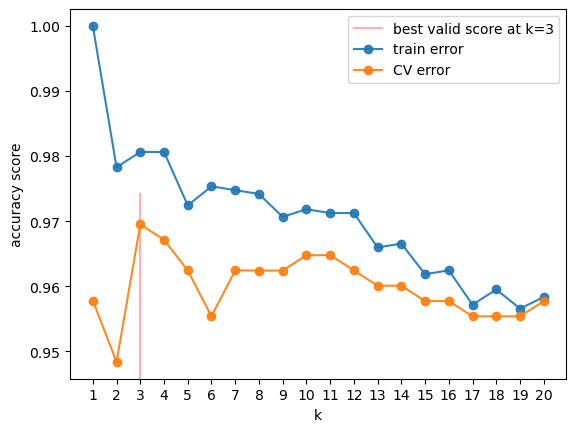

In [21]:
plt.axvline(bestk, 0,0.5, color='r', label="best valid score at k=%d"%bestk, alpha=0.3)
plt.plot(ks[1:], mean_train_scores[1:], marker='o', label='train error', alpha=0.9)
plt.plot(ks[1:], mean_valid_scores[1:], marker='o', label='CV error', alpha=0.9)
plt.legend(loc='upper right')
plt.xticks(range(1,21))
plt.xlabel('k')
plt.ylabel('accuracy score')
plt.show()

#### Final Evaluation

In [22]:
model = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=3)
)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.986013986013986
